<a href="https://colab.research.google.com/github/ana-clara-marques/CD_PUCRIO/blob/main/MVP_ML_%26_Analytics_AnaClaraMarques_202509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MVP: *Machine Learning & Analytics*
**Autor:** Ana Clara de Almeida Marques  

**Data:** 28/09/2025

**Matrícula:** 4052025001106

**Dataset:** [Estações Meteorológicas do INMET PR 2015–2019](https://raw.githubusercontent.com/ana-clara-marques/CD_PUCRIO/refs/heads/main/weather_PR_2015-2019_5estacoes.csv)




## **1. Escopo, objetivo e definição do problema**

- **Contexto do problema**

As estações meteorológicas automáticas do Instituto Nacional de Meteorologia (INMET) contam com diversos sensores que medem uma grande quantidade de informações meteorológicas: precipitação, radiação global, temperatura média do ar, temperatura máxima do ar, temperatura mínima do ar, umidade relativa máxima, umidade relativa mínima, rajada de vento e velocidade média do vento. Entretanto, os **pluviômetros (sensores de chuva) são mais suscetíveis a falhas físicas**, como entupimento por folhas, poeira ou até mesmo pássaros construindo ninhos sobre a abertura do pluviômetro, resultando em leituras incorretas (chuva ausente mesmo quando ocorreu). Já os demais sensores são instalados em abrigos ou estruturas protetoras (termômetros e higrômetros em abrigos ventilados, radiação sob cúpulas transparentes), o que reduz bastante a chance de obstrução física direta. Isso os torna mais confiáveis e estáveis como variáveis de entrada para modelos de predição.

  
- **Objetivo**

Construir um modelo de aprendizado de máquina capaz de **prever a ocorrência de chuva vs. não chuva** em registros horários, utilizando apenas variáveis meteorológicas confiáveis. O modelo será treinado com precipitação como variável alvo, tendo as demais variáveis meteorológicas como preditoras. No uso prático, poderá indicar horas em que há alta probabilidade de chuva mesmo quando o pluviômetro registrou zero, funcionando como ferramenta de qualidade de dados.

- **Dados**

O dataset utilizado neste estudo reúne registros horários no período de 2015 a 2019 (5 anos) de 5 estações meteorológicas automáticas do INMET localizadas no estado do Paraná. A escolha pelo INMET se justifica pelo fato de essas estações contarem com uma ampla gama de sensores, o que possibilita explorar diferentes variáveis para identificar padrões associados à ocorrência de precipitação e enfrentar o problema proposto.

O período de 2015 a 2019 foi escolhido por concentrar um número elevado de estações em operação, já que muitas delas foram instaladas entre 2008 e 2014. Além disso, esse recorte antecede os anos da pandemia, quando houve redução das rotinas de manutenção preventiva e corretiva, o que resultou em maior incidência de falhas e perda de qualidade nos dados.

Os dados foram organizados em um único arquivo CSV e disponibilizados em repositório público da autora no GitHub: [Estações Meteorológicas do INMET PR 2015–2019](https://raw.githubusercontent.com/ana-clara-marques/CD_PUCRIO/refs/heads/main/weather_PR_2015-2019_5estacoes.csv)

- **Tipo de tarefa**

Classificação binária supervisionada, aplicada a dados tabulares de sensores meteorológicos.

- **Área de aplicação**

Ciência de dados aplicada à meteorologia, com foco em qualidade de dados ambientais.

- **Valor para o negócio/usuário**

1. **Operacional**: apoio na detecção de falhas de pluviômetros, contribuindo para manutenção corretiva (ou preventiva, dependendo do uso do modelo).

2. **Científico**: imputação probabilística da ocorrência de chuva em históricos, reduzindo lacunas e inconsistências.

3. **Acadêmico**: estudo de viabilidade de modelos de classificação binária aplicados a séries temporais meteorológicas.


## 2. Reprodutibilidade e ambiente
- Bibliotecas usadas.
- Seeds fixas para reprodutibilidade.

In [ ]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import time

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para pré-processamento e validação
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Modelos de classificação
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, average_precision_score

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score
)


# Fixando seed global para reprodutibilidade
SEED = 42
np.random.seed(SEED)

print("Seed global definida como:", SEED)



Seed global definida como: 42


### 2.2 Definição de Funções

In [ ]:
def _get_scores_continuos(model, X):
    """Extrai score contínuo da classe positiva (proba[:,1] ou decision_function)."""
    if hasattr(model, "predict_proba"):
        try:
            return model.predict_proba(X)[:, 1]
        except Exception:
            pass
    if hasattr(model, "decision_function"):
        try:
            return model.decision_function(X)
        except Exception:
            pass
    return None

def evaluate_classification(y_true, y_pred, scores=None):
    """Métricas principais para validação"""
    met = {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
    }
    if scores is not None:
        try:
            met["roc_auc"] = roc_auc_score(y_true, scores)
        except Exception:
            met["roc_auc"] = np.nan
        try:
            met["pr_auc"] = average_precision_score(y_true, scores)
        except Exception:
            met["pr_auc"] = np.nan
    else:
        met["roc_auc"] = np.nan
        met["pr_auc"]  = np.nan
    return met

def evaluate_model(model, X_test, y_test, name="model"):
    """Avalia um pipeline/modelo completo, retornando um dicionário de nome e métricas."""
    y_pred  = model.predict(X_test)
    scores  = _get_scores_continuos(model, X_test)
    metrics = evaluate_classification(y_test, y_pred, scores)
    return {name: metrics}



## 3. Dados: carga, entendimento e qualidade

**Origem do dataset:**
O dataset reúne registros horários de 5 estações meteorológicas automáticas do INMET localizadas no estado do Paraná, cobrindo o período de 2015 a 2019.

Os dados foram previamente organizados em um único arquivo CSV e disponibilizados em repositório público no GitHub da autora:
https://raw.githubusercontent.com/ana-clara-marques/CD_PUCRIO/refs/heads/main/weather_PR_2015-2019_5estacoes.csv

# Dicionário de variáveis na resolução horária:
- **ESTACAO**: Identificação da estação meteorológica
- **DATA**: Data/hora da observação
- **ANO**: Ano da observação
- **rain_max**: Precipitação horária (mm)
- **rad_max**: Radiação global (kJ/m²)
- **temp_avg**: Temperatura média do ar (°C)
- **temp_max**: Temperatura máxima do ar (°C)
- **temp_min**: Temperatura mínima do ar (°C)
- **hum_max**: Umidade relativa máxima (%)
- **hum_min**: Umidade relativa mínima (%)
- **wind_max**: Rajada de vento (m/s)
- **wind_avg**: Velocidade média do vento (m/s)

# Licença/ética:
Os dados meteorológicos do INMET são públicos e de livre acesso para fins acadêmicos e científicos.




In [ ]:
# Carga dos dados
url = "https://raw.githubusercontent.com/ana-clara-marques/CD_PUCRIO/refs/heads/main/weather_PR_2015-2019_5estacoes.csv"
df = pd.read_csv(url, parse_dates=["DATA"])

# Verificação inicial
print("Formato do dataset:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)

print("\nValores ausentes por coluna:")
print(df.isna().sum())

# Visualizar primeiras linhas
df.head()


Formato do dataset: (1826, 12)

Tipos de dados:
ESTACAO             object
DATA        datetime64[ns]
ANO                  int64
rain_max           float64
rad_max            float64
temp_avg           float64
temp_max           float64
temp_min           float64
hum_max            float64
hum_min            float64
wind_max           float64
wind_avg           float64
dtype: object

Valores ausentes por coluna:
ESTACAO      0
DATA         0
ANO          0
rain_max     0
rad_max      0
temp_avg     0
temp_max     0
temp_min     0
hum_max     17
hum_min     17
wind_max     0
wind_avg     0
dtype: int64


,ESTACAO,DATA,ANO,rain_max,rad_max,temp_avg,temp_max,temp_min,hum_max,hum_min,wind_max,wind_avg
0,A807,2015-01-01,2015,5.6,3415.7,22.941667,28.4,19.2,91.0,53.0,14.7,2.545833
1,A807,2015-01-02,2015,0.4,3698.0,23.516667,30.2,20.7,80.0,45.0,17.4,3.395833
2,A807,2015-01-03,2015,0.2,1486.5,19.875000,21.9,18.2,93.0,75.0,6.5,1.825000
3,A807,2015-01-04,2015,8.0,2729.5,20.870833,26.9,17.8,95.0,51.0,7.6,1.541667
4,A807,2015-01-05,2015,12.2,3546.8,20.812500,27.1,17.7,96.0,57.0,9.7,1.795833



### 3.1 Análise exploratória resumida (EDA)


Premissass iniciais sobre a relação entre a variável-alvo (chuva) e as demais variáveis registradas pela estação meteorológica.

- **Umidade relativa máxima (hum_max):** deve ser maior em horários com chuva. Isso ocorre porque a precipitação está associada a maior disponibilidade de vapor d’água no ar e, ao mesmo tempo, a queda de temperatura causada pelo resfriamento evaporativo eleva a umidade relativa. Como a umidade relativa é função da razão entre a quantidade de vapor d’água presente e a capacidade máxima de saturação do ar (que diminui com a temperatura), episódios chuvosos tendem a registrar valores mais altos de umidade.

- **Rajada de vento (wind_max):** pode ser maior em horários com chuva, já que diversos tipos de sistemas que provocam chuva (frentes frias, tempestades convectivas, sistemas convectivos de mesoescala etc) estão associados a intensificação das correntes decendentes das nuvens e/ou ao aumento do gradiente de pressão, que favorece a intensificação das rajadas de vento.

- **Temperatura mínima (temp_min):** tende a ser menor em horários com chuva, devido à combinação de resfriamento evaporativo e a redução da radiação solar disponível em função da maior cobertura de nuvens durante os eventos de chuva.


chuva
0    0.621577
1    0.378423
Name: proportion, dtype: float64


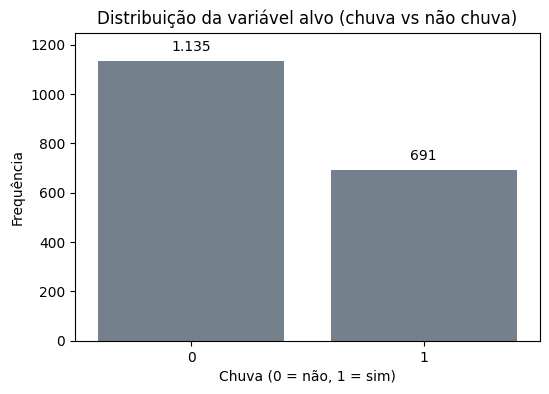

,count,mean,min,25%,50%,75%,max,std
DATA,1826,2017-07-01 12:00:00,2015-01-01 00:00:00,2016-04-01 06:00:00,2017-07-01 12:00:00,2018-09-30 18:00:00,2019-12-31 00:00:00,NaN
ANO,1826.0,2016.999452,2015.0,2016.0,2017.0,2018.0,2019.0,1.414407
rain_max,1826.0,2.108215,0.0,0.0,0.0,1.6,67.6,5.106325
rad_max,1826.0,2442.931325,180.7,1857.575,2492.5,3131.275,4089.2,897.22483
temp_avg,1826.0,18.350085,7.97,15.647056,18.6125,21.073958,26.958333,3.539429
temp_max,1826.0,24.048083,9.4,20.6,24.4,27.5,34.5,4.660909
temp_min,1826.0,14.525137,4.1,11.9,14.9,17.4,22.4,3.58023
hum_max,1809.0,95.33665,51.0,94.0,99.0,100.0,100.0,7.182666
hum_min,1809.0,49.879491,12.0,39.0,49.0,61.0,91.0,14.978741
wind_max,1826.0,8.950548,4.2,7.2,8.4,10.1,22.7,2.605453


Correlação de rain_max com as demais variáveis:
rain_max    1.000000
chuva       0.519944
wind_max    0.287879
temp_min    0.230909
hum_min     0.162458
temp_avg    0.153389
temp_max    0.099033
hum_max     0.054302
wind_avg    0.008950
ANO        -0.032144
rad_max    -0.050497
Name: rain_max, dtype: float64

Correlação de chuva/não chuva com as demais variáveis:
chuva       1.000000
rain_max    0.519944
hum_min     0.383759
wind_max    0.312461
temp_min    0.309337
hum_max     0.134241
wind_avg    0.126976
temp_avg    0.121785
temp_max   -0.019805
ANO        -0.053201
rad_max    -0.227501
Name: chuva, dtype: float64


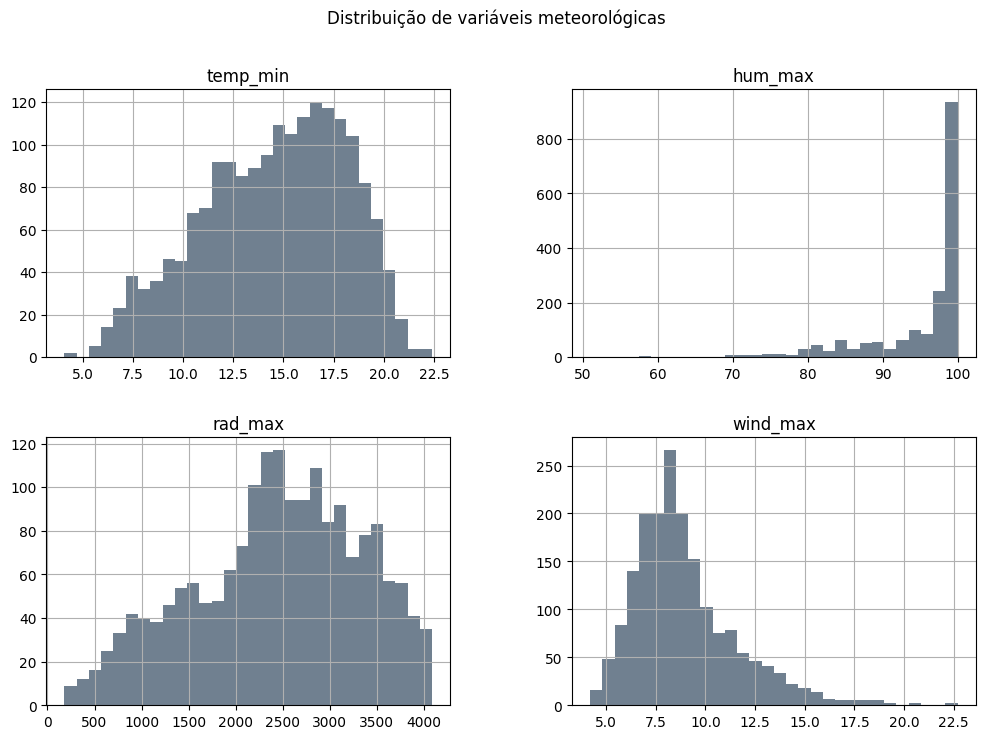

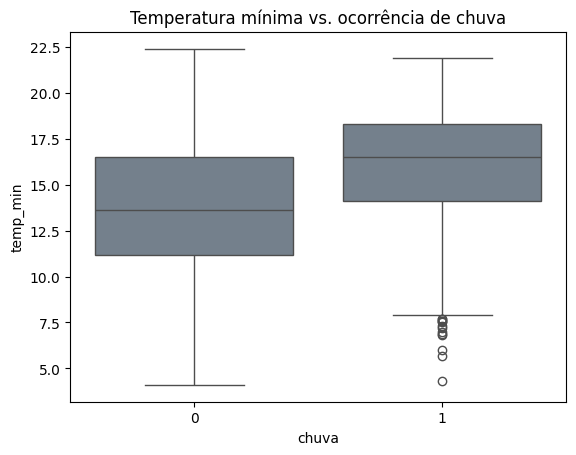

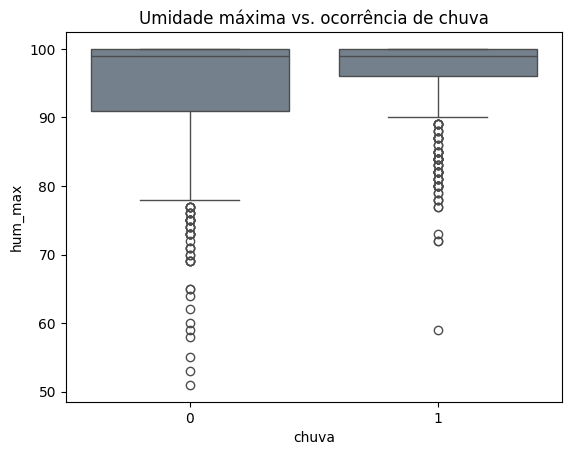

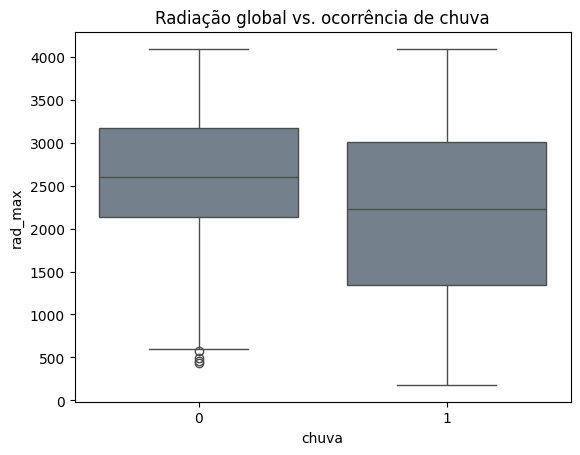

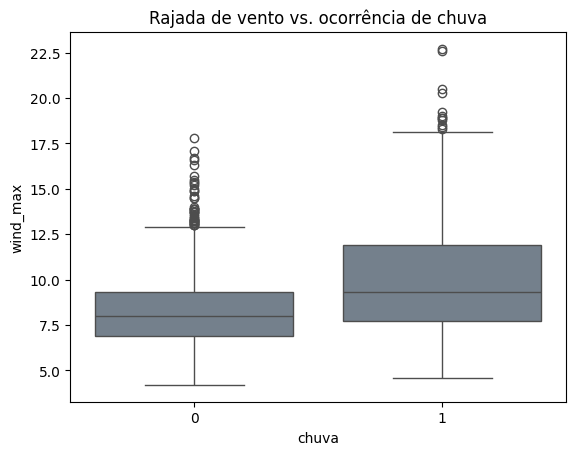

In [ ]:
# Tratar e remover campos vazios (NaN) na coluna rain_max (variável alvo não pode ter ausência de dados)
df['rain_max'] = df['rain_max'].replace(r'^\s*$', pd.NA, regex=True)
df = df.dropna(subset=['rain_max']).reset_index(drop=True)

# Foi escolhido o limiar de chuva horária como 0.2 mm/h por ser um valor fora do erro do instrumento de medição
# o limiar de 0.2 mm é comumente usado em estudos de meteorologia para classificação de chuva
df["chuva"] = (df["rain_max"] > 0.2).astype(int)  # criação de variável: target binário (0 = não chuva, 1 = chuva)
print(df["chuva"].value_counts(normalize=True))

## Gráfico de chuva vs não chuva
plt.figure(figsize=(6,4))
ax = sns.countplot(x="chuva", data=df, order=[0,1], color="slategrey")
ax.set_title("Distribuição da variável alvo (chuva vs não chuva)")
ax.set_xlabel("Chuva (0 = não, 1 = sim)")
ax.set_ylabel("Frequência")
ymax = max(p.get_height() for p in ax.patches)
ax.set_ylim(0, ymax * 1.10)

for p in ax.patches:
    v = int(p.get_height())
    ax.annotate(f"{v:,}".replace(",", "."),
                (p.get_x() + p.get_width()/2, v),
                ha="center", va="bottom", xytext=(0, 5), textcoords="offset points")
plt.show()


# Estatísticas descritivas das variáveis numéricas
display(df.describe().T)

# Calculando a correlação entre a chuva horária (rain_max) e as demais variáveis
corr = df.corr(numeric_only=True)["rain_max"].sort_values(ascending=False)
print("Correlação de rain_max com as demais variáveis:")
print(corr)

# Calculando a correlação entre a ocorrência de chuva/não chuva (chuva) e as demais variáveis
corr2 = df.corr(numeric_only=True)["chuva"].sort_values(ascending=False)
print("\nCorrelação de chuva/não chuva com as demais variáveis:")
print(corr2)

# Histogramas de algumas variáveis-chave
num_cols = ["temp_min", "hum_max", "rad_max", "wind_max"]
df[num_cols].hist(bins=30, figsize=(12,8),color="slategrey")
plt.suptitle("Distribuição de variáveis meteorológicas")
plt.show()

# Relação entre chuva e variáveis explicativas
sns.boxplot(x="chuva", y="temp_min", data=df,color="slategrey")
plt.title("Temperatura mínima vs. ocorrência de chuva")
plt.show()

sns.boxplot(x="chuva", y="hum_max", data=df,color="slategrey")
plt.title("Umidade máxima vs. ocorrência de chuva")
plt.show()

sns.boxplot(x="chuva", y="rad_max", data=df,color="slategrey")
plt.title("Radiação global vs. ocorrência de chuva")
plt.show()

sns.boxplot(x="chuva", y="wind_max", data=df,color="slategrey")
plt.title("Rajada de vento vs. ocorrência de chuva")
plt.show()


### 4. Definição do target, variáveis preditoras e divisão em treino e teste
- Remoção de valores fisicamente impossíveis
- Tratamento e limpeza dos dados


In [ ]:
### Remoção de outliers (valores fisicamente impossíveis)

# Definir limites físicos razoáveis para cada variável
limites = {
    "temp_avg": (-20, 50),     # temperatura média em °C
    "temp_min": (-25, 50),     # temperatura mínima em °C
    "temp_max": (-20, 50),     # temperatura máxima em °C
    "hum_min": (0, 100),       # umidade relativa mínima em %
    "hum_max": (0, 100),       # umidade relativa máxima em %
    "rad_max": (0, 4500),      # radiação global em kJ/m²
    "wind_avg": (0, 60),       # vento médio (em 10 min) em m/s (60 m/s ≈ 216 km/h)
    "wind_max": (0, 80),       # rajada máxima (3 segundos) em m/s (80 m/s ≈ 288 km/h)
    "rain_max": (0, 130)       # precipitação horária em mm (123,6 mm/h é o maior registro histórico do Brasil)
}

# Aplicar os filtros
for col, (low, high) in limites.items():
    n_antes = df.shape[0]
    df = df[(df[col] >= low) & (df[col] <= high)]
    n_depois = df.shape[0]
    print(f"{col}: removidos {n_antes - n_depois} registros fora do intervalo [{low}, {high}]")

# Resetar o índice após a filtragem
df = df.reset_index(drop=True)

temp_avg: removidos 0 registros fora do intervalo [-20, 50]
temp_min: removidos 0 registros fora do intervalo [-25, 50]
temp_max: removidos 0 registros fora do intervalo [-20, 50]
hum_min: removidos 17 registros fora do intervalo [0, 100]
hum_max: removidos 0 registros fora do intervalo [0, 100]
rad_max: removidos 0 registros fora do intervalo [0, 4500]
wind_avg: removidos 0 registros fora do intervalo [0, 60]
wind_max: removidos 0 registros fora do intervalo [0, 80]
rain_max: removidos 0 registros fora do intervalo [0, 130]



Nesta etapa foi definida a variável **alvo** do problema (`chuva`), que assume valor 1 quando a precipitação horária (`rain_max`) é maior que 0,2 mm e 0 caso contrário. As **variáveis preditoras (features)** são compostas apenas por atributos meteorológicos numéricos, excluindo:

- `chuva` (alvo do modelo),
- `rain_max` (usada para criar o alvo, não deve ser entrada),
- `ESTACAO`, `DATA` e `ANO` (identificadores).

Em seguida, o dataset foi dividido em dois subconjuntos:
- **Treino (80%)**: usado para ajustar os modelos,
- **Teste (20%)**: usado apenas para avaliar o desempenho em dados nunca vistos.

Foi utilizada a opção `stratify=y` para garantir que a proporção de registros de chuva e não chuva seja preservada tanto no treino quanto no teste, evitando distorções causadas pelo desbalanceamento natural do dataset.  
O parâmetro `random_state=SEED` assegura a **reprodutibilidade** da divisão.

Por fim, foram impressos o tamanho de cada subconjunto e a proporção de registros de chuva em cada um, como forma de validação da divisão realizada.


In [ ]:
# Tipo de problema: CLASSIFICAÇÃO

# Definindo target e features
target = "chuva"
features_full = [
    c for c in df.columns
    if c not in ["chuva", "ESTACAO", "DATA", "ANO", "rain_max"]
]

print("Target:", "chuva")
print("N features (full):", len(features_full))
print("Features (full):", features_full)

# Hold-out 80/20 estratificado (reprodutível)
X = df[features_full].copy()
y = df["chuva"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Proporção de chuva (train):", round(y_train.mean(), 3))
print("Proporção de chuva (test):", round(y_test.mean(), 3))

Target: chuva
N features (full): 8
Features (full): ['rad_max', 'temp_avg', 'temp_max', 'temp_min', 'hum_max', 'hum_min', 'wind_max', 'wind_avg']
Treino: (1447, 8) | Teste: (362, 8)
Proporção de chuva (train): 0.372
Proporção de chuva (test): 0.373



## 5. Tratamento de dados e **Pipeline** de pré-processamento




In [ ]:
# Todas as features usadas são numéricas
num_cols = X_train.columns.tolist()

# Pré-processamento COM escala (para Logistic, SVM e KNN)
numeric_pipe_scale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess_scale_full = ColumnTransformer(
    transformers=[("num", numeric_pipe_scale, num_cols)],
    remainder="drop"
)

# Pré-processamento SEM escala (para RandomForest e baseline)
numeric_pipe_noscale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
preprocess_noscale_full = ColumnTransformer(
    transformers=[("num", numeric_pipe_noscale, num_cols)],
    remainder="drop"
)

# Seleção univariada por informação mútua (será aplicada DENTRO dos pipelines de Logistic/SVM/KNN)
# Observação: 'k' será tratado como hiperparâmetro e ajustado por CV no Bloco 7.
k_grid = [3, 4, 5, 6, 7, 8]
def selector_kbest(k):
    return SelectKBest(score_func=mutual_info_classif, k=k)

print("Pré-processadores prontos:")
print("- preprocess_scale_full     (para Logistic/SVM/KNN, com escala)")
print("- preprocess_noscale_full   (para RandomForest/Dummy, sem escala)")
print("K candidatos para SelectKBest:", k_grid)

Pré-processadores prontos:
- preprocess_scale_full     (para Logistic/SVM/KNN, com escala)
- preprocess_noscale_full   (para RandomForest/Dummy, sem escala)
K candidatos para SelectKBest: [3, 4, 5, 6, 7, 8]


## 6. Baseline e modelos candidatos

### Modelos considerados e pré-processamento

| Modelo | Tipo | Pré-processamento | Seleção de atributos | Observações / Hiperparâmetros iniciais |
|---|---|---|---|---|
| **DummyClassifier** | Baseline | Imputação (mediana), **sem** escala | — | Estratégia: `most_frequent` (classe majoritária). |
| **LogisticRegression** | Linear, binária | Imputação (mediana) + **StandardScaler** | `SelectKBest(mutual_info_classif, k)` | `max_iter=1000`, `class_weight=balanced`. `k` será tunado por validação cruzada. |
| **LinearSVC** | SVM linear (margem linear) | Imputação (mediana) + **StandardScaler** | `SelectKBest(mutual_info_classif, k)` | `class_weight=balanced`. `k` será tunado por validação cruzada. |
| **KNN** | Baseado em distância | Imputação (mediana) + **StandardScaler** | `SelectKBest(mutual_info_classif, k)` | `n_neighbors=11` (inicial). Tanto `k` quanto `n_neighbors` serão ajustados por validação cruzada. |
| **RandomForest** | Ensemble de árvores | Imputação (mediana), **sem** escala | — (usa todas as features) | `n_estimators=300`, `class_weight=balanced_subsample`, `n_jobs=-1`. |

---

**Nota sobre SVM:** o kernel RBF apresentou custo computacional elevado para o volume de dados (~18 mil instâncias).  
Optou-se por **SVM linear (LinearSVC)** com `class_weight="balanced"`, mantendo o pré-processamento com  
padronização e seleção univariada (`SelectKBest`). Essa escolha viabilizou o treinamento em tempo adequado sem perda substancial de desempenho.


In [ ]:
baseline = Pipeline(steps=[
    ("pre", preprocess_noscale_full),  # imputação (mediana), sem escala
    ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
])

# Modelos candidatos
models = {
    "LogisticRegression": Pipeline(steps=[
        ("pre", preprocess_scale_full),
        ("kbest", SelectKBest(score_func=mutual_info_classif, k=5)),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED))
    ]),
    "LinearSVC": Pipeline(steps=[
        ("pre", preprocess_scale_full),
        ("kbest", SelectKBest(score_func=mutual_info_classif, k=5)),
        ("model", LinearSVC(class_weight="balanced", random_state=SEED, max_iter=2000))
    ]),
    "KNN": Pipeline(steps=[
        ("pre", preprocess_scale_full),
        ("kbest", SelectKBest(score_func=mutual_info_classif, k=5)),
        ("model", KNeighborsClassifier(n_neighbors=11))
    ]),
    "RandomForest": Pipeline(steps=[
        ("pre", preprocess_noscale_full),
        ("model", RandomForestClassifier(
            n_estimators=300,
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ])
}

print("Modelos candidatos:", list(models.keys()))

Modelos candidatos: ['LogisticRegression', 'LinearSVC', 'KNN', 'RandomForest']



### 6.1 Treino e avaliação rápida (baseline vs candidatos)


In [ ]:
results = {}

# baseline
baseline.fit(X_train, y_train)
results.update(evaluate_model(baseline, X_test, y_test, name="Baseline"))

# candidatos
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    results.update(evaluate_model(pipe, X_test, y_test, name=name))

results_df = pd.DataFrame(results).T.sort_values("f1", ascending=False)
display(results_df)


,accuracy,precision,recall,f1,roc_auc,pr_auc
LinearSVC,0.762431,0.648485,0.792593,0.713333,0.852602,0.757738
LogisticRegression,0.756906,0.644172,0.777778,0.704698,0.852211,0.758672
RandomForest,0.751381,0.685950,0.614815,0.648438,0.843775,0.742300
KNN,0.726519,0.640625,0.607407,0.623574,0.819726,0.727375
Baseline,0.627072,0.000000,0.000000,0.000000,0.500000,0.372928



## 7. Validação e Otimização de Hiperparâmetros



In [ ]:
# Validação cruzada estratificada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Usaremos múltiplas métricas, mas vamos "refit" pelo F1 (classe positiva = chuva)
scoring = {
    "f1": "f1",
    "recall": "recall",
    "precision": "precision",
    "accuracy": "accuracy"
}
refit_metric = "f1"

# Espaços de busca
search_spaces = {
    "LogisticRegression": {
        "kbest__k": [3, 4, 5, 6, 7, 8],
        "model__C": [0.1, 1, 10]
        # class_weight já está "balanced"; solver padrão 'lbfgs' com penalty L2
    },
    "SVM_linear": {
        "kbest__k": [3, 4, 5, 6, 7, 8],
        "model__C": [0.1, 1, 10],
        # Para datasets grandes
    },
    "KNN": {
        "kbest__k": [3, 4, 5, 6, 7, 8],
        "model__n_neighbors": [5, 11, 21],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]  # Manhattan vs Euclidiana
    },
    "RandomForest": {
        "model__n_estimators": [200, 300, 500],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    }
}

# Executar buscas (RandomizedSearch enxerga listas como escolha aleatória; com grids curtos, funciona bem)
best_models = {}
summary_rows = []

for name, pipe in models.items():
    if name not in search_spaces:
        continue

    param_dist = search_spaces[name]
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=min(10, sum(len(v) if isinstance(v, list) else 10 for v in param_dist.values())),  # iterações moderadas
        cv=cv,
        scoring=scoring,
        refit=refit_metric,
        random_state=SEED,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    summary_rows.append({
        "modelo": name,
        "best_f1_cv": round(search.best_score_, 4),
        "best_params": search.best_params_
    })

# Tabela-resumo do tuning (F1 médio em CV e melhores hiperparâmetros)
tuning_summary = pd.DataFrame(summary_rows).sort_values("best_f1_cv", ascending=False)
display(tuning_summary)


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


,modelo,best_f1_cv,best_params
0,LogisticRegression,0.7318,"{'model__C': 1, 'kbest__k': 8}"
2,RandomForest,0.7221,"{'model__n_estimators': 300, 'model__min_sampl..."
1,KNN,0.6861,"{'model__weights': 'uniform', 'model__p': 2, '..."



## 8. Avaliação final, análise de erros e limitações


Melhor modelo segundo CV: LogisticRegression
Hiperparâmetros: {'memory': None, 'steps': [('pre', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['rad_max', 'temp_avg', 'temp_max', 'temp_min',
                                  'hum_max', 'hum_min', 'wind_max',
                                  'wind_avg'])])), ('kbest', SelectKBest(k=8, score_func=<function mutual_info_classif at 0x7b38979c0a40>)), ('model', LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42))], 'transform_input': None, 'verbose': False, 'pre': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                

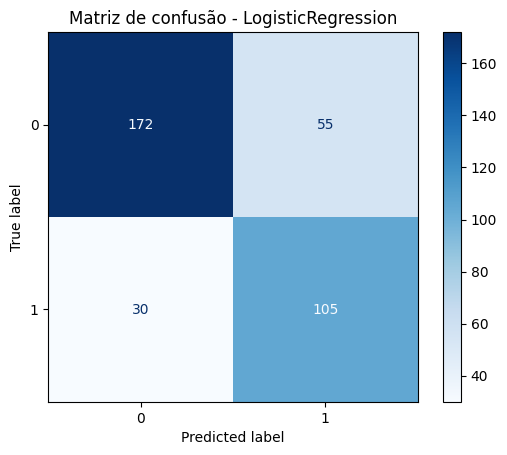

In [ ]:

# Escolher o melhor modelo pelo F1 médio em CV
best_name = tuning_summary.iloc[0]["modelo"]
best_model = best_models[best_name]

print(f"Melhor modelo segundo CV: {best_name}")
print("Hiperparâmetros:", best_model.get_params())

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)

print("\n--- Relatório de Classificação (Teste) ---")
print(classification_report(y_test, y_pred, zero_division=0, digits=3))

# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title(f"Matriz de confusão - {best_name}")
plt.show()

In [ ]:
res_best = evaluate_model(best_model, X_test, y_test, best_name)
pd.DataFrame(res_best).T


,accuracy,precision,recall,f1,roc_auc,pr_auc
LogisticRegression,0.765193,0.65625,0.777778,0.711864,0.852211,0.779898


### Avaliação Final no Conjunto de Teste

O melhor modelo após o tuning foi **Logistic Regression**, com os seguintes parâmetros:
- `C=1` (regularização L2 moderada)
- `kbest__k=8` (todas as variáveis consideradas)
- `class_weight="balanced"`

No conjunto de teste, os principais resultados foram:

- **Accuracy**: 0.765  
- **F1 (chuva)**: 0.712  
- **Recall (chuva)**: 0.778  
- **Precisão (chuva)**: 0.656  

A matriz de confusão mostra que o modelo consegue identificar bem os eventos de chuva, mesmo com a classe sendo menos frequente. O recall elevado (77,8%) indica que o modelo consegue **recuperar a maioria dos eventos chuvosos**, reduzindo o risco de falsos negativos. Por outro lado, a precisão menor (65,6%) significa que o modelo pode sinalizar chuva em alguns casos sem precipitação real, o que pode gerar um nível significativo de falsos positivos, mas é aceitável no contexto do problema, já que o objetivo principal é detectar falhas de pluviômetro.

### Limitações
- **Dados**: a base se restringe a 5 estações e 5 anos no Paraná; A base utilizada no treino dos modelos pode já conter um viés de subestimativa dos eventos de chuva.
- **Métricas**: acurácia é inflada pela classe majoritária, por isso a utilização do F1 e recall da chuva foram priorizados.  
- **Generalização**: o desempenho pode variar em regiões com padrão de precipitação diferentes, regiões com outro tipo de vegetação e sistemas meteorológicos atuantes.

## 9. Engenharia de atributos

**O que foi feito agora**

- Seleção univariada com SelectKBest(mutual_info_classif), aprendida apenas no treino dentro do Pipeline (evita vazamento).

- Padronização (StandardScaler) aplicada somente aos modelos sensíveis à escala (Logistic, LinearSVC, KNN).

- Sem codificação categórica (todas as features são numéricas).

- Sem criação de lags nesta versão básica para manter o escopo do MVP enxuto.

**O que poderia melhorar (próximos incrementos de engenharia)**

- Sazonalidade e ciclo diurno: adicionar mês, mês_sin/cos, hora_sin/cos para capturar padrões sazonais e horários.

- Lags e janelas móveis: médias/máximas das últimas 1–3 h de temp, umidade, vento, radiação etc

- Atributos de localização da estação: latitude, longitude, altitude, distância do oceano e formato da orografia da região — podem capturar padrões orográficos.

- Interações entre variáveis: produtos/razões como hum_max / temp_avg, wind_max * rad_max.

- Sazonalidade da chuva: índice binário “estação chuvosa” para localidades em que essa definição se aplica (por exemplo, em Goiás).

- Validações por estação/tempo: usar GroupKFold por estação e/ou TimeSeriesSplit para avaliar robustez espacial/temporal.

## 11. Boas práticas e rastreabilidade

- Baseline claro (DummyClassifier) e comparação com modelos mais fortes.

- Pipelines em todos os modelos para evitar vazamento (imputação, escala e seleção aprendidos só no treino/CV).

- Sementes fixas (SEED=42) para reprodutibilidade.

- Validação estratificada (k=10) com métrica principal F1 (chuva) e métricas secundárias (precision/recall/accuracy).

- Documentação de decisões: troca de SVM RBF → LinearSVC por custo computacional; class_weight="balanced" para lidar com desbalanceamento.

- Código limpo: importações no topo, funções reutilizáveis, impressão de shapes/proporções.

- Tempo de execução: tuning com espaços de busca enxutos para garantir avaliação em tempo razoável.

## 12. Conclusões e próximos passos

**Conclusões**

- O melhor modelo segundo a CV (k=10) foi a Regressão Logística com C=1 e kbest__k=8.

- No teste, obteve Accuracy ≈ 0.77 e F1 (chuva) ≈ 0.71, com Recall (chuva) ≈ 0.78.

- O desempenho atende ao objetivo do MVP: detectar eventos chuvosos com boa sensibilidade, mesmo quando o pluviômetro pode falhar.

Trade-offs

- Maior recall da chuva implica redução de precisão (alguns falsos positivos). Para o caso de uso (qualidade e redundância de medição), isso é aceitável.

- Modelos lineares são mais interpretáveis, mas podem perder relações não lineares; RandomForest performou próximo, oferecendo robustez a não linearidades.

**Próximos passos**

1. Features temporais (lags, janelas, ciclo diurno) e metadados de estação (altitude, localização).

2. Validação por estação (GroupKFold) para testar generalização espacial.

3. Curva Precision-Recall e ajuste de limiar (threshold tuning) para otimizar o trade-off conforme o custo de FP/FN.

4. Integração com dados externos (radar/satélite/reanálises) para reduzir incerteza.